<a href="https://colab.research.google.com/github/theodorosx/Project_GreenTech/blob/main/CO2%26ModelCarAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation et import des différents modules

In [ ]:
!pip install shap
!pip install eli5
!pip install lime

     |████████████████████████████████| 358kB 8.5MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489397 sha256=431a4bc54d921d5e109c0b4fcfbedbc3b4cfffafd598b88d1f0f68effe54f13b
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap
     |████████████████████████████████| 112kB 9.0MB/s 
     |████████████████████████████████| 276kB 7.3MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=35d5e81ab9a9913dc6cef7cfcc8704f50b448c11e2cabe3cc84958f6bf502c84
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
#Libraires pour la visualisation de données

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#Librairies pour le machine learning

from sklearn import linear_model
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn import decomposition
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
import sklearn.neural_network
from sklearn.model_selection import GridSearchCV

#Pour évaluer l'algorithme
from sklearn.metrics import mean_absolute_error,r2_score
import time


#Pour l'étude des features

import shap
import eli5
from eli5.sklearn import PermutationImportance
import lime
import lime.lime_tabular

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [ ]:
#On importe le dataset 

df = pd.read_csv("/content/CO2 Emissions_Canada.csv")


In [ ]:
#On regarde le nombre de valeurs manquantes, important pour savoir si on doit les traiter


df.isnull().sum()

Make                                0
Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
dtype: int64

In [ ]:
#Quelques informations supplémentaires sur le dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [ ]:
df.sample(5)

Make  ... CO2 Emissions(g/km)
7136          MAZDA  ...                 189
6180  MERCEDES-BENZ  ...                 324
3580       CHRYSLER  ...                 242
6587            BMW  ...                 231
2920        LINCOLN  ...                 322

[5 rows x 12 columns]

In [ ]:
df.describe()

Engine Size(L)  ...  CO2 Emissions(g/km)
count     7385.000000  ...          7385.000000
mean         3.160068  ...           250.584699
std          1.354170  ...            58.512679
min          0.900000  ...            96.000000
25%          2.000000  ...           208.000000
50%          3.000000  ...           246.000000
75%          3.700000  ...           288.000000
max          8.400000  ...           522.000000

[8 rows x 7 columns]

# Nettoyage des données

On prépare en amont les données par rapport à la problématique, on supprime les variables innutiles, on remplace les données manquantes, et on change les données de catégorie en données numériques

In [ ]:
#On renomme la colonne cible de manière plus simple

df.rename(columns={'CO2 Emissions(g/km)' : 'CO2_emission'}, inplace=True)



On enlève la colonne redondante 'Fuel Consumption Comb (mpg)'

In [ ]:
df=df.drop(['Fuel Consumption Comb (mpg)'],axis=1)


On remplaces les sous catégories de transmission par des catégories plus générales

In [ ]:
df['Transmission'] = np.where(df['Transmission'].isin(['A4','A5','A6','A7','A8','A9','A10']),"Automatic",df['Transmission'])
df['Transmission'] = np.where(df['Transmission'].isin(["AM5", "AM6", "AM7", "AM8", "AM9"]),"Automated Manual",df['Transmission'])
df['Transmission'] = np.where(df['Transmission'].isin(["AS4", "AS5", "AS6", "AS7", "AS8", "AS9", "AS10"]),"Automatic with Select Shift",df['Transmission'])
df['Transmission'] = np.where(df['Transmission'].isin(["AV", "AV6", "AV7", "AV8", "AV10"]),"Continuously Variable",df['Transmission'])
df['Transmission'] = np.where(df['Transmission'].isin(["M5", "M6", "M7"]),"Manual",df['Transmission'])

Afin de simplifier les calculs et l'interprétabilité, on regroupe les données de consommation et de taille de moteur en différentes catégories.

Cette méthode permet de mieux traîter les variables continues.

In [ ]:
#20 sous catégories de consommation et 10 sous catégorie de taille de moteur

#On retient nos "paniers" pour pouvoir y assigner les nouveaux véhicules à tester une fois l'algorithme entraîné

df['CityConsBin'],CityConsBin = pd.cut(df['Fuel Consumption City (L/100 km)'], 20,retbins=True)

df['HwyConsBin'],HwyConsBin = pd.cut(df['Fuel Consumption Hwy (L/100 km)'], 20,retbins=True)

df['CombConsBin'],CombConsBin = pd.cut(df['Fuel Consumption Comb (L/100 km)'], 20,retbins=True)

df['EngineSizeBin'],EngineSizeBin = pd.cut(df['Engine Size(L)'], 10,retbins=True)

## Création de variables

Dans cette partie nous pourrions créer n'importe quelle nouvelle variable combinaisons d'autres qui nous semblerait intéressante. Cela pourrait être une colonne "véhicule sportif" qui se base sur une valeur seuil de taille de moteur et de nombre de cylindres par exemple.

In [ ]:
#Apperçu des données sur lesquelles on va travailler

df.head()

Make       Model Vehicle Class  ...    HwyConsBin   CombConsBin  EngineSizeBin
0  ACURA         ILX       COMPACT  ...  (6.49, 7.32]    (7.4, 8.5]    (1.65, 2.4]
1  ACURA         ILX       COMPACT  ...  (7.32, 8.15]    (8.5, 9.6]    (1.65, 2.4]
2  ACURA  ILX HYBRID       COMPACT  ...  (5.66, 6.49]    (5.2, 6.3]  (0.893, 1.65]
3  ACURA     MDX 4WD   SUV - SMALL  ...  (8.98, 9.81]  (10.7, 11.8]    (3.15, 3.9]
4  ACURA     RDX AWD   SUV - SMALL  ...  (8.15, 8.98]   (9.6, 10.7]    (3.15, 3.9]

[5 rows x 15 columns]

Nous allons explorer nos données avant d'encoder les variables de catégories, cela sera plus lisible

# Visualisation des données



In [ ]:
#On explore un peu plus les données 

df['Cylinders'].value_counts()


4     3220
6     2446
8     1402
12     151
3       95
10      42
5       26
16       3
Name: Cylinders, dtype: int64

In [ ]:
df['Transmission'].value_counts()

Automatic with Select Shift    3127
Automatic                      1851
Manual                         1185
Automated Manual                646
Continuously Variable           576
Name: Transmission, dtype: int64

In [ ]:
df['Fuel Type'].value_counts()

X    3637
Z    3202
E     370
D     175
N       1
Name: Fuel Type, dtype: int64

## Quelques graphiques d'exploration des données

### Répartition des constructeurs

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text major ticklabel objects>)

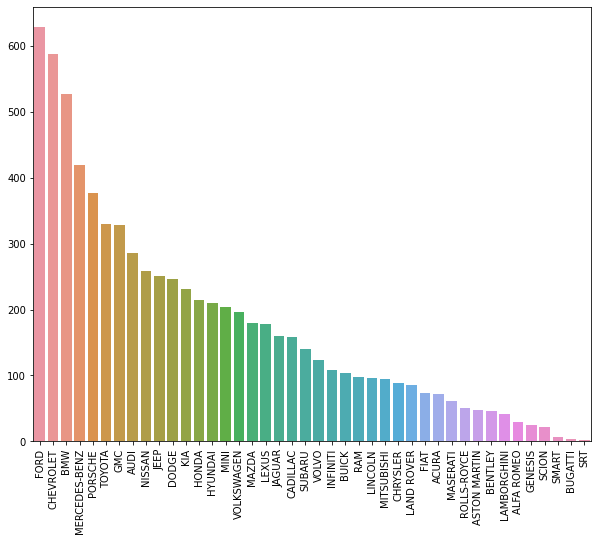

In [ ]:
#Regardons quels types de véhicules sont représentés dans notre dataset

mkI = df['Make'].value_counts().index
mkV = df['Make'].value_counts().values
plt.figure(figsize = (10,8))
sns.barplot(mkI,mkV)
plt.xticks(rotation='vertical')

### Répartition des types de véhicules

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

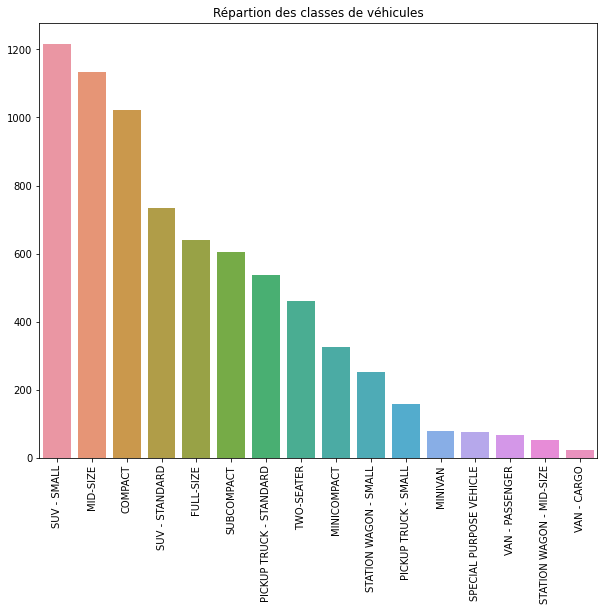

In [ ]:
mkI = df['Vehicle Class'].value_counts().index
mkV = df['Vehicle Class'].value_counts().values
plt.figure(figsize = (10,8))
plt.title("Répartion des classes de véhicules")
sns.barplot(mkI,mkV)
plt.xticks(rotation='vertical')

### Apperçu de la consommation des véhicules

In [ ]:
#Etudions de plus près les données concernant la consommation de carburant

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


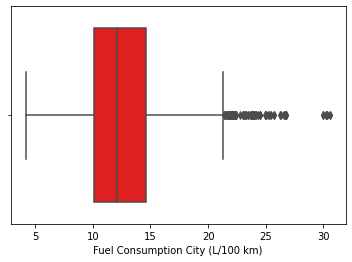

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


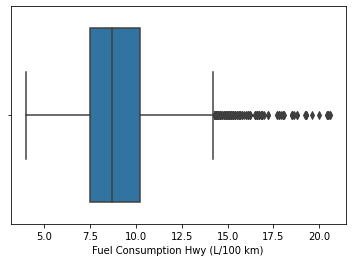

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


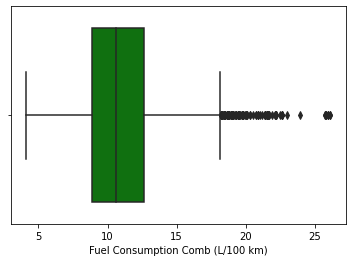

In [ ]:
sns.boxplot(df['Fuel Consumption City (L/100 km)'], color = "red")
plt.show()
sns.boxplot(df['Fuel Consumption Hwy (L/100 km)'])
plt.show()
sns.boxplot(df['Fuel Consumption Comb (L/100 km)'], color = 'green')
plt.show()

### Table de corrélation des différentes variables

Cylinders                           0.832644
Engine Size(L)                      0.851145
Fuel Consumption Hwy (L/100 km)     0.883536
Fuel Consumption Comb (L/100 km)    0.918052
Fuel Consumption City (L/100 km)    0.919592
CO2_emission                        1.000000
Name: CO2_emission, dtype: float64


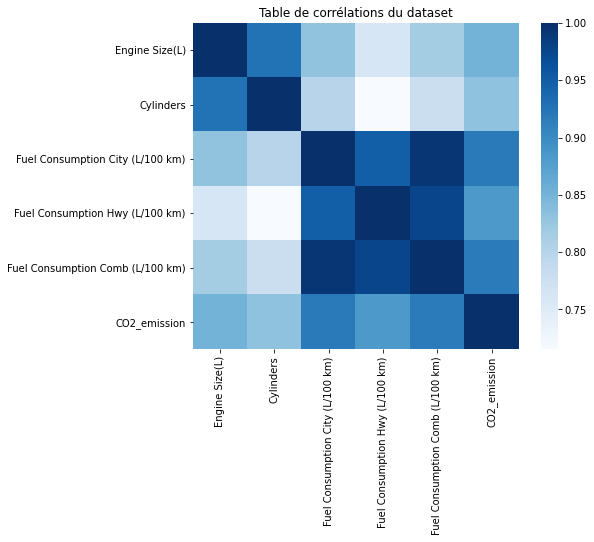

In [ ]:
#On fait un heatmap pour voir la corrélation de chaque variables

print(df.corr()['CO2_emission'].sort_values())

plt.figure(figsize = (8,6))
plt.title("Table de corrélations du dataset")
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap = 'Blues', square = True)

### Relations par paires des données

Text(0.5, 0.98, 'Pairplot du dataset')

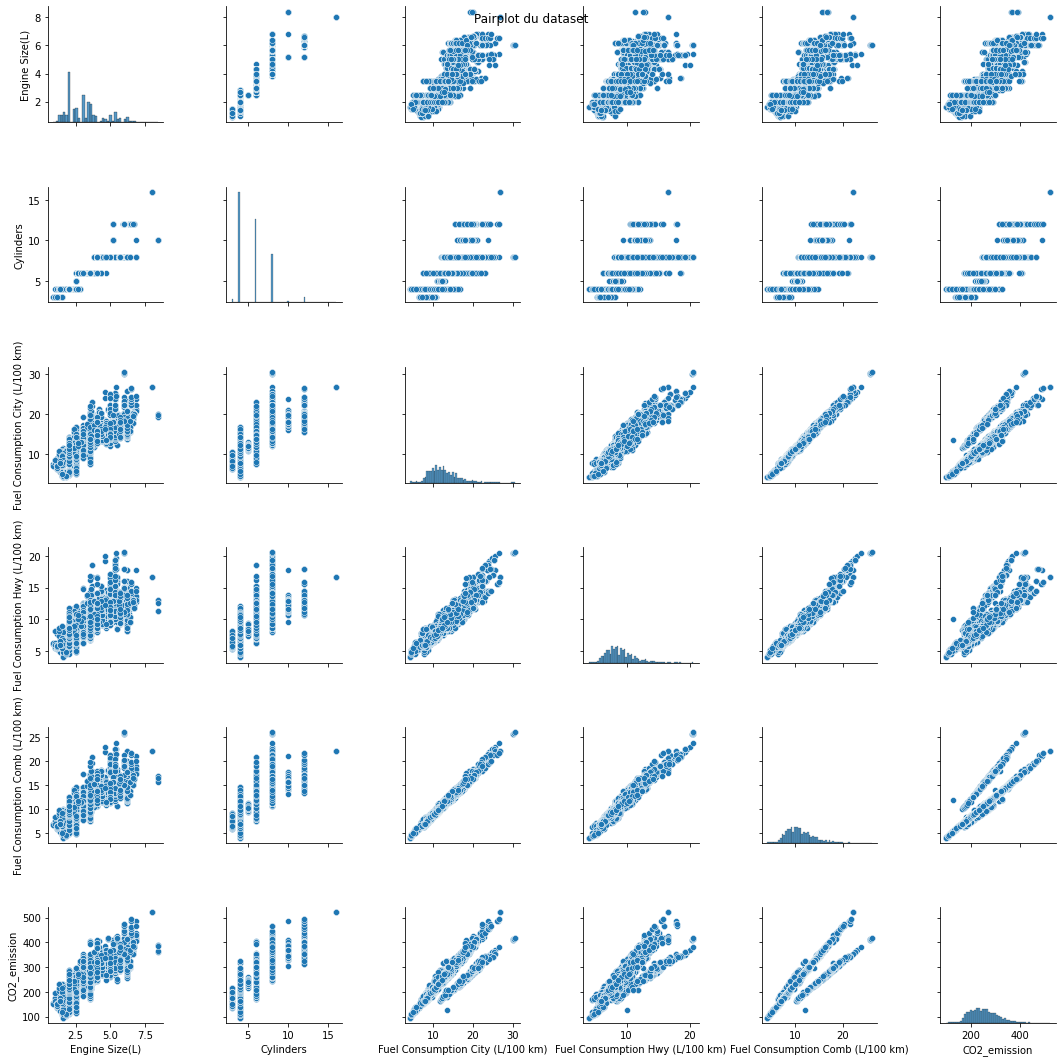

In [ ]:
#On peut tracer l'ensemble des pairplot pour avoir une première idée des tendances qui se dégagent
g=sns.pairplot(df)
g.fig.suptitle("Pairplot du dataset", fontsize=12)

## Emissions de CO2 en fonction des autres variables

In [ ]:
#Etudions les emissions de CO2 par rapport à chaque variable

### CO2 en fonction du type de véhicule

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

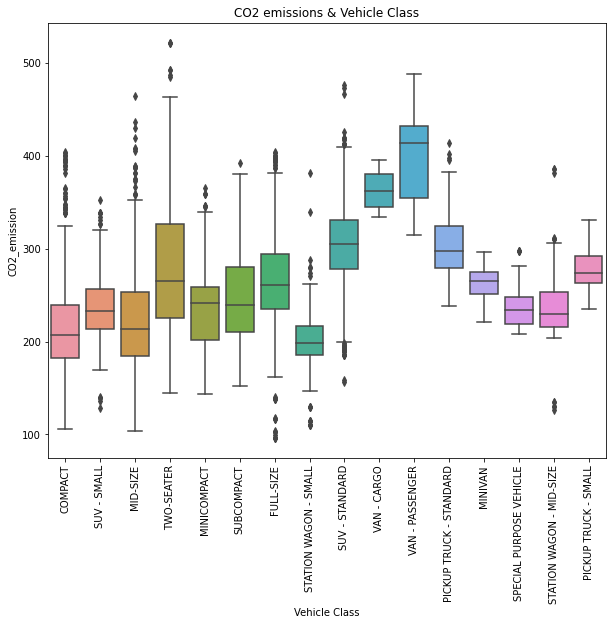

In [ ]:
#CO2 et classe de véhicule :


plt.figure(figsize = (10,8))
plt.title("CO2 emissions & Vehicle Class")
sns.boxplot(x="Vehicle Class", y="CO2_emission", data=df)
plt.xticks(rotation = 'vertical')

### CO2 en fonction de la marque du véhicule

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text major ticklabel objects>)

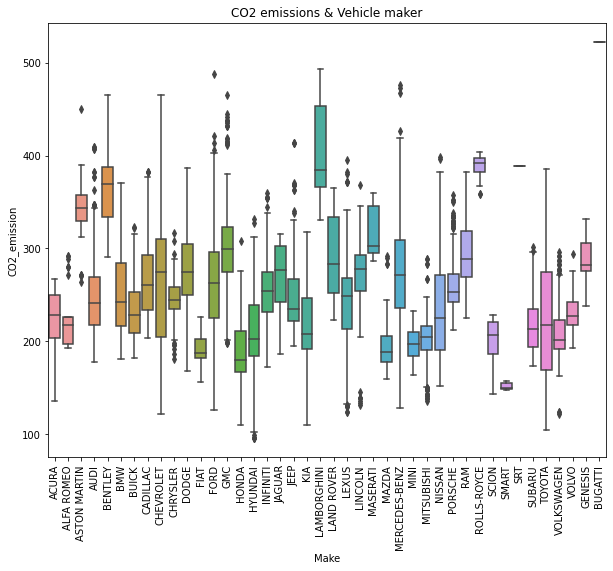

In [ ]:
#CO2 et marque de véhicule :


plt.figure(figsize = (10,8))
plt.title("CO2 emissions & Vehicle maker")
sns.boxplot(x="Make", y="CO2_emission", data=df)
plt.xticks(rotation = 'vertical')

### CO2 en fonction du type de fuel


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

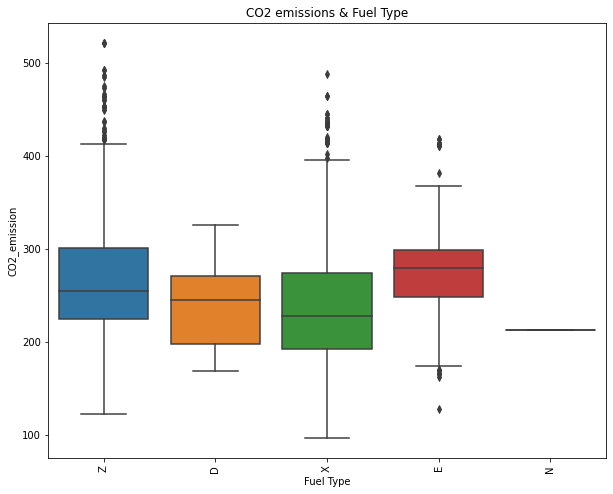

In [ ]:
#CO2 et type de fuel 

plt.figure(figsize = (10,8))
plt.title("CO2 emissions & Fuel Type")
sns.boxplot(x="Fuel Type", y="CO2_emission", data=df)
plt.xticks(rotation = 'vertical')

### CO2 en fonction des cylindrées

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

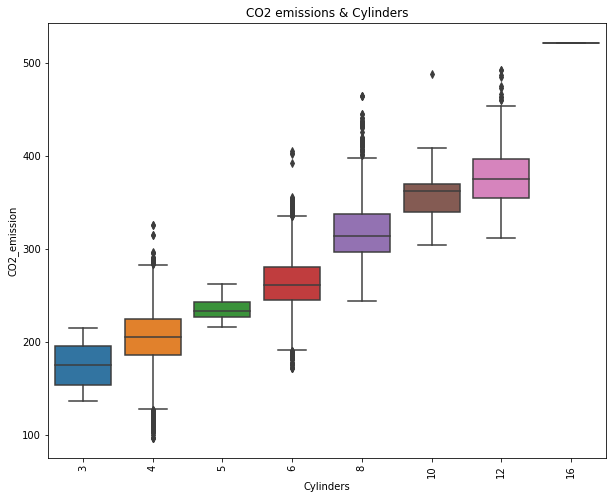

In [ ]:
#CO2 et cylindrées 

plt.figure(figsize = (10,8))
plt.title("CO2 emissions & Cylinders")
sns.boxplot(x="Cylinders", y="CO2_emission", data=df)
plt.xticks(rotation = 'vertical')

# Apprentissage artificiel

## Mise en forme des données

Les données de catégories doivent être transformées en nombres pour être interprétées par notre réseau de neurones, nous allons donc préparer des encodeurs réutilisables pour les données futures.

In [ ]:

label_fuel=LabelEncoder()
label_fuel.fit(df['Fuel Type'])



label_transmission=LabelEncoder()
label_transmission.fit(df['Transmission'])


label_class=LabelEncoder()
label_class.fit(df['Vehicle Class'])


label_CityConsBinCode=LabelEncoder()
label_CityConsBinCode.fit(df['CityConsBin'])


label_HwyConsBinCode=LabelEncoder()
label_HwyConsBinCode.fit(df['HwyConsBin'])


label_CombConsBinCode=LabelEncoder()
label_CombConsBinCode.fit(df['CombConsBin'])


label_EngineSizeBinCode=LabelEncoder()
label_EngineSizeBinCode.fit(df['EngineSizeBin'])



LabelEncoder()

On créé 2 fonctions de mise en forme des données :

*   Une pour créer des catégories pour les variables continues
*   Une pour encoder les variables de catégories



In [ ]:
#On définit quelle colonne est la colonne cible
Target=['CO2_emission']



In [ ]:
#On créé de nouvelles entrées dans le dataframe avec les sous catégories

def mise_en_forme_bins(df):
  df['CityConsBin'] = pd.cut(df['Fuel Consumption City (L/100 km)'], bins=CityConsBin)

  df['HwyConsBin'] = pd.cut(df['Fuel Consumption Hwy (L/100 km)'],  bins=HwyConsBin)

  df['CombConsBin'] = pd.cut(df['Fuel Consumption Comb (L/100 km)'],  bins=CombConsBin)

  df['EngineSizeBin'] = pd.cut(df['Engine Size(L)'],  bins=EngineSizeBin)




def mise_en_forme_code(df):

  #On créé de nouvelles colonnes dans le dataframe avec les données encodées
  df['Fuel_Code'] = label_fuel.transform(df['Fuel Type'])
  df['Transimission_Code'] = label_transmission.transform(df['Transmission'])
  df['Class_Code'] = label_class.transform(df['Vehicle Class'])
  df['CityConsBinCode'] = label_CityConsBinCode.transform(df['CityConsBin'])
  df['HwyConsBinCode'] = label_HwyConsBinCode.transform(df['HwyConsBin'])
  df['CombConsBinCode'] = label_CombConsBinCode.transform(df['CombConsBin'])
  df['EngineSizeBinCode'] = label_EngineSizeBinCode.transform(df['EngineSizeBin'])

  #On créé des masques pour récupérer les données encodées ou non plus tard
  
  data_x = ['Vehicle Class','Engine Size(L)', 'Cylinders', 'Transmission','Fuel Type', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)'] #Les noms de variables les données originales
  data_x_calc = ['Class_Code','Engine Size(L)', 'Cylinders', 'Transimission_Code','Fuel_Code', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)'] #Les catégories encodées mais avec variables continues
  data_xy =  Target + data_x  #Les données et la donnée cible
  print('Original X Y: ', data_xy, '\n')


  #Les données avec catégories pour les variables continues et encodées
  data_x_bin = ['Class_Code','EngineSizeBinCode', 'Cylinders', 'Transimission_Code', 'Fuel_Code', 'CityConsBinCode', 'HwyConsBinCode','CombConsBinCode']
  data_xy_bin = Target + data_x_bin
  print('Bin X Y: ', data_xy_bin, '\n')


  #define x and y variables for dummy features original
  data_dummy = pd.get_dummies(df[data_x])
  data_x_dummy = data_dummy.columns.tolist()
  data_xy_dummy = Target + data_x_dummy
  print('Dummy X Y: ', data_xy_dummy, '\n')

  return(data_x_calc,data_x_bin,data_x_dummy,data_dummy)










In [ ]:
#On encode nos données d'entrée

data_x_calc,data_x_bin,data_x_dummy,data_dummy=mise_en_forme_code(df)

Original X Y:  ['CO2_emission', 'Vehicle Class', 'Engine Size(L)', 'Cylinders', 'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)'] 

Bin X Y:  ['CO2_emission', 'Class_Code', 'EngineSizeBinCode', 'Cylinders', 'Transimission_Code', 'Fuel_Code', 'CityConsBinCode', 'HwyConsBinCode', 'CombConsBinCode'] 

Dummy X Y:  ['CO2_emission', 'Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Vehicle Class_COMPACT', 'Vehicle Class_FULL-SIZE', 'Vehicle Class_MID-SIZE', 'Vehicle Class_MINICOMPACT', 'Vehicle Class_MINIVAN', 'Vehicle Class_PICKUP TRUCK - SMALL', 'Vehicle Class_PICKUP TRUCK - STANDARD', 'Vehicle Class_SPECIAL PURPOSE VEHICLE', 'Vehicle Class_STATION WAGON - MID-SIZE', 'Vehicle Class_STATION WAGON - SMALL', 'Vehicle Class_SUBCOMPACT', 'Vehicle Class_SUV - SMALL', 'Vehicle Class_SUV - STANDARD', 'Vehicle Class_TWO-SEATER

In [ ]:
df.head()

Make       Model  ... CombConsBinCode  EngineSizeBinCode
0  ACURA         ILX  ...               3                  1
1  ACURA         ILX  ...               4                  1
2  ACURA  ILX HYBRID  ...               1                  0
3  ACURA     MDX 4WD  ...               6                  3
4  ACURA     RDX AWD  ...               5                  3

[5 rows x 22 columns]

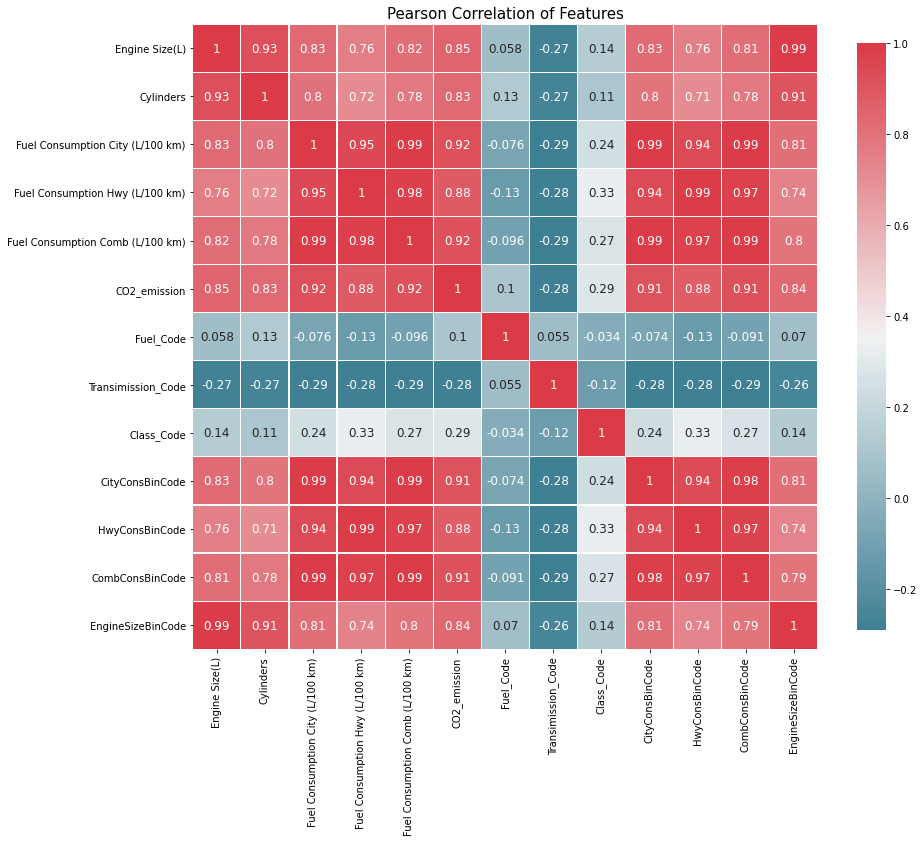

In [ ]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df)

## Création du modèle et choix des paramètres

In [ ]:
#On split en train set et test set, on pourra tester l'efficacité de l'algo avec ou sans encodage
train_x, test_x, train_y, test_y = model_selection.train_test_split(df[data_x_calc], df[Target], random_state = 0)
train_x_bin, test_x_bin, train_y_bin, test_y_bin = model_selection.train_test_split(df[data_x_bin], df[Target] , random_state = 0)
train_x_dummy, test_x_dummy, train_y_dummy, test_y_dummy = model_selection.train_test_split(data_dummy[data_x_dummy], df[Target], random_state = 0)


print("Data Shape: {}".format(df.shape))
print("Train Shape: {}".format(train_x.shape))
print("Test Shape: {}".format(test_x.shape))

train_x_bin.head()

Data Shape: (7385, 22)
Train Shape: (5538, 8)
Test Shape: (1847, 8)


Class_Code  EngineSizeBinCode  ...  HwyConsBinCode  CombConsBinCode
871            3                  3  ...               5                5
7058          13                  7  ...              13               15
2635          15                  3  ...              11               10
1172           0                  2  ...               4                5
4386           2                  2  ...               6                7

[5 rows x 8 columns]

On utilise un multi layer perceptron mais on pourra tester d'autres algorithmes

In [ ]:
model = sklearn.neural_network.MLPRegressor(max_iter=10000,random_state=None)

In [ ]:
#Dictionnaire des paramètres à tester

#Le premier permet de tester plus de paramètres et de sélectionner les meilleurs mais prendra beaucoup plus de temps.

parameter_space = {
    'hidden_layer_sizes': [(100,),(30,30,),(10,10,10,)],
    'activation': ['relu','tanh'],
    'solver': ['adam','lbfgs'],
    'alpha': [0.0001,0.001,0.01,0.1],
    'learning_rate': ['constant','adaptative'],
}

"""parameter_space ={
    'hidden_layer_sizes': [(100,)],
    'activation': ['relu'],
    'solver': ['lbfgs'],
    'alpha': [0.1],
    'learning_rate': ['constant'],
}"""

"parameter_space ={\n    'hidden_layer_sizes': [(100,)],\n    'activation': ['relu'],\n    'solver': ['lbfgs'],\n    'alpha': [0.1],\n    'learning_rate': ['constant'],\n}"

Entrainement du modèle avec score

In [ ]:
#On effectue le gridsearch et on fit sur les données d'entrainement

rgr = GridSearchCV(model, parameter_space, n_jobs=-1, cv=2)
rgr.fit(train_x_bin, train_y_bin.values.ravel())

# Best paramete set
print('Best parameters found:\n', rgr.best_params_)
means = rgr.cv_results_['mean_test_score']
stds = rgr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, rgr.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.990 (+/-0.002) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
0.991 (+/-0.001) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
nan (+/-nan) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptative', 'solver': 'adam'}
nan (+/-nan) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptative', 'solver': 'lbfgs'}
0.986 (+/-0.015) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (30, 30), 'learning_rate': 'constant', 'solver': 'adam'}
0.991 (+/-0.001) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (30, 30), 'learning_rate': 'constant', 'solver': 'lbfgs'}
nan (+/-nan) for {'activati

In [ ]:

#Fonction pour calculer la précision de notre algorithme

def print_accuracy(f,data):
    y=(np.array(test_y_bin)).reshape((1847,))
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(data) - y)**2))))
    time.sleep(0.5) # to let the print get out before any progress bars
    print("Mean Absolute test error = {0}".format(mean_absolute_error(y,f(data))))
    time.sleep(0.5) # to let the print get out before any progress bars
    print("R2 test error = {0}".format(r2_score(y,f(data))))
    time.sleep(0.5) # to let the print get out before any progress bars




In [ ]:
rgr.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'solver': 'lbfgs'}

In [ ]:
print("Scores avec GridSearch")
print_accuracy(rgr.predict,test_x_bin)

Scores avec GridSearch
Root mean squared test error = 5.55536429243595
Mean Absolute test error = 4.258241700291403
R2 test error = 0.9910568743759622


## Test avec de nouvelles valeurs



### Import du fichier CSV

In [ ]:
df_a_evaluer=pd.read_csv("/content/test.csv")

In [ ]:
df_a_evaluer.head()

Make  ... Fuel Consumption Comb (L/100 km)
0  RENAULT  ...                              4.4
1  RENAULT  ...                              5.7

[2 rows x 10 columns]

### Préparation des données

In [ ]:
mise_en_forme_bins(df_a_evaluer)

In [ ]:
df_a_evaluer

Make   Model Vehicle Class  ...     HwyConsBin   CombConsBin  EngineSizeBin
0  RENAULT  SCENIC       COMPACT  ...  (3.983, 4.83]  (4.078, 5.2]  (0.893, 1.65]
1  RENAULT  TWINGO   MINICOMPACT  ...  (3.983, 4.83]    (5.2, 6.3]  (0.893, 1.65]

[2 rows x 14 columns]

In [ ]:
mise_en_forme_code(df_a_evaluer)

Original X Y:  ['CO2_emission', 'Vehicle Class', 'Engine Size(L)', 'Cylinders', 'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)'] 

Bin X Y:  ['CO2_emission', 'Class_Code', 'EngineSizeBinCode', 'Cylinders', 'Transimission_Code', 'Fuel_Code', 'CityConsBinCode', 'HwyConsBinCode', 'CombConsBinCode'] 

Dummy X Y:  ['CO2_emission', 'Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Vehicle Class_COMPACT', 'Vehicle Class_MINICOMPACT', 'Transmission_Automatic', 'Transmission_Manual', 'Fuel Type_D', 'Fuel Type_X'] 



(['Class_Code',
  'Engine Size(L)',
  'Cylinders',
  'Transimission_Code',
  'Fuel_Code',
  'Fuel Consumption City (L/100 km)',
  'Fuel Consumption Hwy (L/100 km)',
  'Fuel Consumption Comb (L/100 km)'],
 ['Class_Code',
  'EngineSizeBinCode',
  'Cylinders',
  'Transimission_Code',
  'Fuel_Code',
  'CityConsBinCode',
  'HwyConsBinCode',
  'CombConsBinCode'],
 ['Engine Size(L)',
  'Cylinders',
  'Fuel Consumption City (L/100 km)',
  'Fuel Consumption Hwy (L/100 km)',
  'Fuel Consumption Comb (L/100 km)',
  'Vehicle Class_COMPACT',
  'Vehicle Class_MINICOMPACT',
  'Transmission_Automatic',
  'Transmission_Manual',
  'Fuel Type_D',
  'Fuel Type_X'],
    Engine Size(L)  Cylinders  ...  Fuel Type_D  Fuel Type_X
 0             1.5          4  ...            1            0
 1             1.2          4  ...            0            1
 
 [2 rows x 11 columns])

In [ ]:
df_a_evaluer

Make   Model  ... CombConsBinCode  EngineSizeBinCode
0  RENAULT  SCENIC  ...               0                  0
1  RENAULT  TWINGO  ...               1                  0

[2 rows x 21 columns]

### Prédiction

In [ ]:
resultats=rgr.predict(df_a_evaluer[data_x_bin])

In [ ]:
resultats

array([122.92848083, 137.48575562])

### Export du dataframe de résultats vers un fichier CSV

In [ ]:
df_resultats=pd.concat([df_a_evaluer[['Make','Model']],pd.DataFrame(data=resultats,columns=['CO2_emissions'])],axis=1)

In [ ]:
df_resultats.head()

Make   Model  CO2_emissions
0  RENAULT  SCENIC     122.928481
1  RENAULT  TWINGO     137.485756

In [ ]:
df_resultats.to_csv('/content/resultats.csv')

# Etude des features

## Avec SHAP

In [ ]:
import shap

shap.initjs()

# pour améliorer le temps d'execution on peut réduire le jeu de données à partir de X_test

x_test_sample=shap.sample(test_x_bin,100)

#Si l'on souhaite avoir l'interprétabilité des résultats du fichiers à évaluer on rajoute les données pour SHAP :
x_test_sample=x_test_sample.append(df_a_evaluer[data_x_bin])

explainer = shap.KernelExplainer(rgr.predict, x_test_sample)

shap_values = explainer.shap_values(x_test_sample)



Using 102 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Summary plot

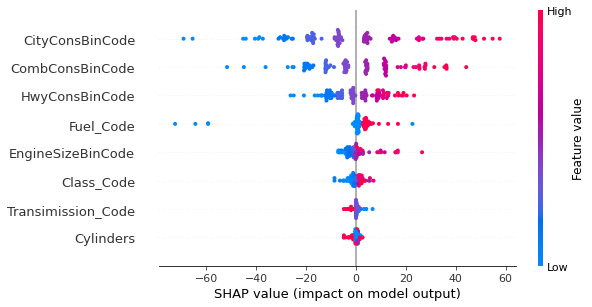

In [ ]:
shap.summary_plot(shap_values, x_test_sample, feature_names=data_x_bin)



## Summary bar plot

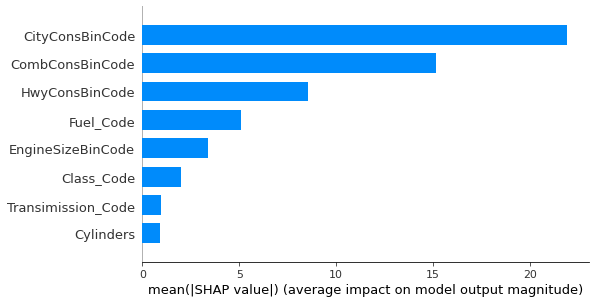

In [ ]:
shap.summary_plot(shap_values, features=x_test_sample, feature_names=data_x_bin, plot_type='bar')

## Individual plot

In [ ]:
shap.initjs()
 

i = 101
shap.force_plot(explainer.expected_value, shap_values[i,:], features=x_test_sample.iloc[i,:], feature_names=data_x_bin)




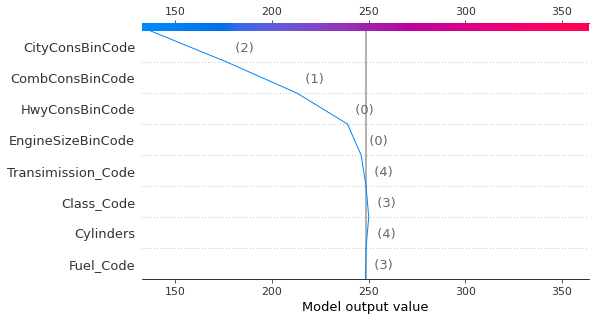

In [ ]:
shap.initjs()

shap.decision_plot(explainer.expected_value, shap_values[i,:], x_test_sample.iloc[i,:])

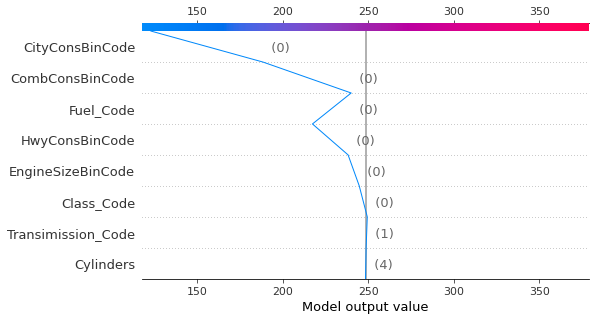

In [ ]:
shap.initjs()

shap.decision_plot(explainer.expected_value, shap_values[100,:], x_test_sample.iloc[100,:])

## Méthode CHI2 pour l'importance des features

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
best_features = SelectKBest(score_func=chi2,k=train_x_bin.shape[1])

In [ ]:
fit = best_features.fit(train_x_bin,train_y_bin)

In [ ]:
best = pd.DataFrame(fit.scores_,columns=['scores'])

In [ ]:
best['var'] = train_x_bin.columns

In [ ]:
best.sort_values(by='scores' ,ascending=False)

scores                 var
1  5958.245672   EngineSizeBinCode
7  5850.316651     CombConsBinCode
5  5797.778800     CityConsBinCode
6  5770.072083      HwyConsBinCode
0  3813.439512          Class_Code
2  2583.594892           Cylinders
3   754.623084  Transimission_Code
4   180.082319           Fuel_Code

## Eli5 

In [ ]:
perm = PermutationImportance(rgr, random_state=1).fit(train_x_bin,train_y_bin)
eli5.show_weights(perm, feature_names = data_x_bin)

## LIME

In [ ]:
explainer2 = lime.lime_tabular.LimeTabularExplainer(np.array(train_x_bin), feature_names=data_x_bin, class_names=['Emission'], verbose=True, mode='regression')

Intercept 283.915264073602
Prediction_local [162.34147211]
Right: 122.92848082636738


<Figure size 432x288 with 0 Axes>

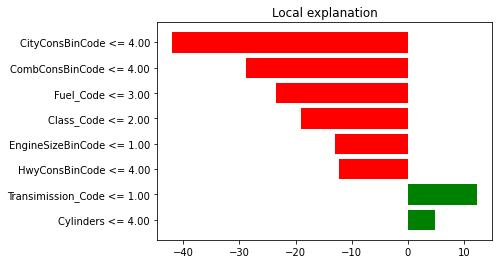

In [ ]:
exp = explainer2.explain_instance(x_test_sample.iloc[100], 
     rgr.predict, num_features=8)
plt.figure()
exp.as_pyplot_figure()
plt.show()

In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)
exp.save_to_file('limeExplainer.html')